In [151]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
import tensorflow

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation,GlobalAveragePooling2D


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

Cross Validation 70-30

In [152]:
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import shutil

# Ruta donde se encuentran tus archivos originales
source_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/training_set/normal'

# Rutas de destino para los conjuntos de prueba y validación
train_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/data_train/normal'
val_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/data_val/normal'

# Porcentaje de archivos que irán al conjunto de prueba
test_percent = 0.7

# Crear el directorio de prueba si no existe
if not os.path.exists(train_path):
    os.makedirs(train_path)

# Crear el directorio de validación si no existe
if not os.path.exists(val_path):
    os.makedirs(val_path)

# Listar todos los archivos en el directorio fuente
file_list = os.listdir(source_path)

# Calcular la cantidad de archivos para el conjunto de prueba y de validación
test_count = int(len(file_list) * test_percent)
val_count = len(file_list) - test_count

# Mezclar aleatoriamente la lista de archivos
random.shuffle(file_list)

# Mover archivos al conjunto de prueba
for file in file_list[:test_count]:
    source_file = os.path.join(source_path, file)
    dest_file = os.path.join(train_path, file)
    shutil.move(source_file, dest_file)

# Mover archivos al conjunto de validación
for file in file_list[test_count:test_count + val_count]:
    source_file = os.path.join(source_path, file)
    dest_file = os.path.join(val_path, file)
    shutil.move(source_file, dest_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [153]:
import os
import random
import shutil

# Ruta donde se encuentran tus archivos originales
source_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/training_set/glaucoma'

# Rutas de destino para los conjuntos de prueba y validación
train_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/data_train/glaucoma'
val_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/data_val/glaucoma'

# Porcentaje de archivos que irán al conjunto de prueba
test_percent = 0.7

# Crear el directorio de prueba si no existe
if not os.path.exists(train_path):
    os.makedirs(train_path)

# Crear el directorio de validación si no existe
if not os.path.exists(val_path):
    os.makedirs(val_path)

# Listar todos los archivos en el directorio fuente
file_list = os.listdir(source_path)

# Calcular la cantidad de archivos para el conjunto de prueba y de validación
test_count = int(len(file_list) * test_percent)
val_count = len(file_list) - test_count

# Mezclar aleatoriamente la lista de archivos
random.shuffle(file_list)

# Mover archivos al conjunto de prueba
for file in file_list[:test_count]:
    source_file = os.path.join(source_path, file)
    dest_file = os.path.join(train_path, file)
    shutil.move(source_file, dest_file)

# Mover archivos al conjunto de validación
for file in file_list[test_count:test_count + val_count]:
    source_file = os.path.join(source_path, file)
    dest_file = os.path.join(val_path, file)
    shutil.move(source_file, dest_file)

In [154]:
from google.colab import drive
drive.mount('/content/drive')

train_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/data_train'
test_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/test_set'
val_path = r'/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/data_val'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


COnvertir la imagenes a pixels

normal


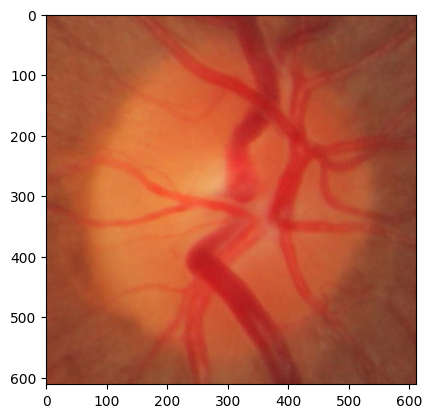

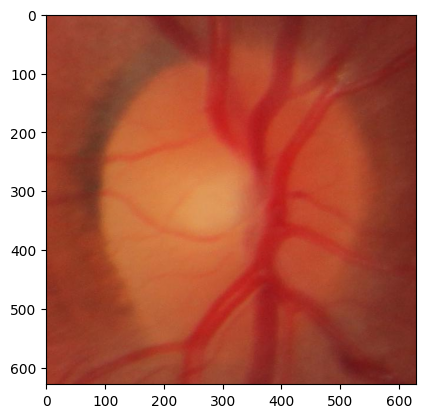

glaucoma


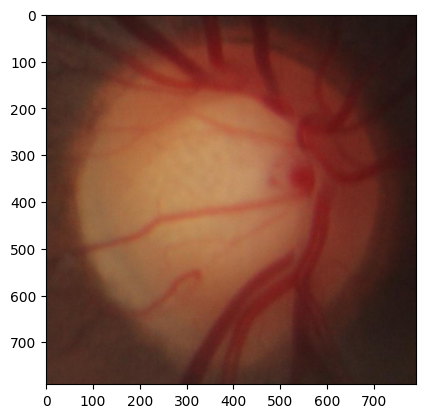

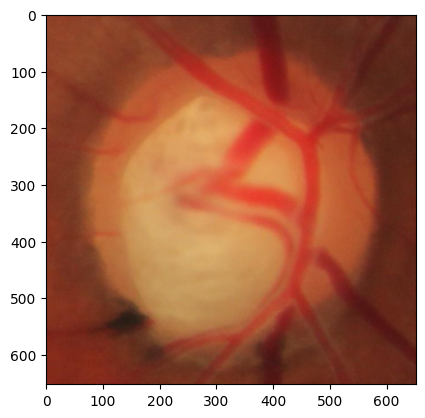

In [155]:
for folder in os.listdir(train_path):
    sub_path = train_path + "/" + folder

    print(folder)
    for i in range(2):
        temp_path = os.listdir(sub_path)[i]
        temp_path = sub_path + "/" + temp_path
        img = mpimg.imread(temp_path)
        imgplot = plt.imshow(img)
        plt.show()

In [156]:
def apply_augmentations(image, size):
    # Rotaciones aleatorias entre -30° y 30°
    angle = np.random.randint(-30, 31)
    M = cv2.getRotationMatrix2D((size[0] / 2, size[1] / 2), angle, 1)
    image = cv2.warpAffine(image, M, size)

    # Volteo horizontal aleatorio
    if np.random.random() > 0.5:
        image = cv2.flip(image, 1)

    # Volteo vertical aleatorio
    if np.random.random() > 0.5:
        image = cv2.flip(image, 0)

    # Zoom aleatorio entre 0.8 y 1.2
    zoom = np.random.uniform(0.8, 1.2)
    h, w, _ = image.shape
    new_h, new_w = int(h * zoom), int(w * zoom)
    image = cv2.resize(image, (new_w, new_h))

    return image

In [188]:
def apply_mask(image, mask):
    if image is not None and mask is not None:
        # Asegurarse de que image y mask sean matrices de NumPy válidas
        if isinstance(image, np.ndarray) and isinstance(mask, np.ndarray):
            # Verificar si la imagen y la máscara tienen el mismo tamaño
            if image.shape[:2] != mask.shape[:2]:
                # Redimensionar la máscara para que tenga el mismo tamaño que la imagen
                mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
            # Asegurarse de que ambas matrices tengan el mismo tipo de dato (CV_8U)
            image = image.astype(np.uint8)
            mask = mask.astype(np.uint8)

            # Aplicar la máscara para mantener solo la parte blanca
            masked_image = cv2.bitwise_and(image, image, mask=mask)
            return masked_image
        else:
            print("image y mask deben ser matrices de NumPy válidas")
    else:
        print("image o mask es None, no se puede aplicar la máscara")



In [189]:
def resize_image(image, size):
    return cv2.resize(image, size)

In [194]:
from google.colab import drive
drive.mount('/content/drive')
import os

mascara_glaucoma_path = '/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/RIM-ONE_segmentation/Glaucoma'
mascara_normal_path = '/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/RIM-ONE_segmentation/Normal'

def imagearray(path, size):
    data = []
    for folder in os.listdir(path):
        sub_path = os.path.join(path, folder)

        for img in os.listdir(sub_path):
            image_path = os.path.join(sub_path, img)
            img_name, img_extension = os.path.splitext(img)  # Separar el nombre del archivo y la extensión

            # Agregar "-Disc-T" al nombre del archivo y eliminar la extensión
            img_name_with_disc_t = img_name + "-1-Disc-T.png"

            if img_name_with_disc_t in os.listdir(mascara_glaucoma_path):
                path_glaucoma_mask = os.path.join(mascara_glaucoma_path, img_name_with_disc_t)

                # Cargar la imagen de máscara
                img_mask = cv2.imread(path_glaucoma_mask)

                # Cargar la máscara
                mascara = cv2.imread(path_glaucoma_mask, cv2.IMREAD_GRAYSCALE)

                if img_mask is not None and mascara is not None:
                    mascara = cv2.resize(mascara, size)
                    img_arr = cv2.imread(image_path)

                    if img_arr is not None:
                        img_arr = apply_mask(img_arr, mascara)
                        img_arr = cv2.resize(img_arr, size)

                        # Aplicar las transformaciones a la imagen
                        img_arr = apply_augmentations(img_arr, size)


                        data.append(img_arr)
                    else:
                        print(f"Error al cargar la imagen: {image_path}")
                else:
                    print(f"Error al cargar la máscara: {path_glaucoma_mask}")
            else:
                if img_name_with_disc_t in os.listdir(mascara_normal_path):
                    path_normal_mask = os.path.join(mascara_normal_path, img_name_with_disc_t)

                    # Cargar la imagen de máscara
                    img_mask = cv2.imread(path_normal_mask)

                    # Cargar la máscara
                    mascara = cv2.imread(path_normal_mask, cv2.IMREAD_GRAYSCALE)

                    if img_mask is not None and mascara is not None:
                        mascara = cv2.resize(mascara, size)
                        img_arr = cv2.imread(image_path)

                        if img_arr is not None:
                            img_arr = apply_mask(img_arr, mascara)
                            img_arr = cv2.resize(img_arr, size)

                            # Aplicar las transformaciones a la imagen
                            img_arr = apply_augmentations(img_arr, size)
                            data.append(img_arr)
                        else:
                            print(f"Error al cargar la imagen: {image_path}")
                    else:
                        print(f"Error al cargar la máscara: {path_normal_mask}")

    return data


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [197]:
size = (224,224)

train = imagearray(train_path, size)
test = imagearray(test_path, size)
val = imagearray(val_path, size)



train


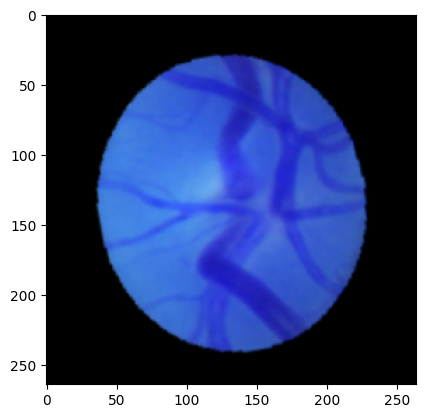

train


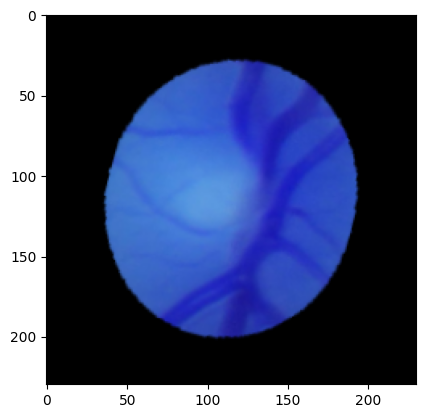

test


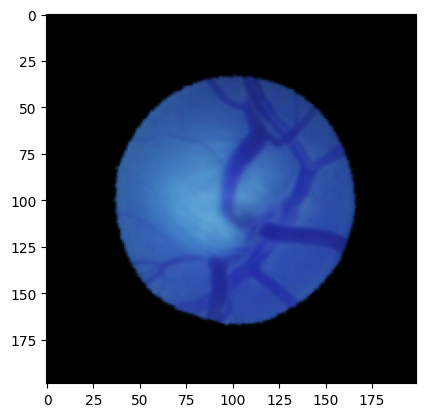

test


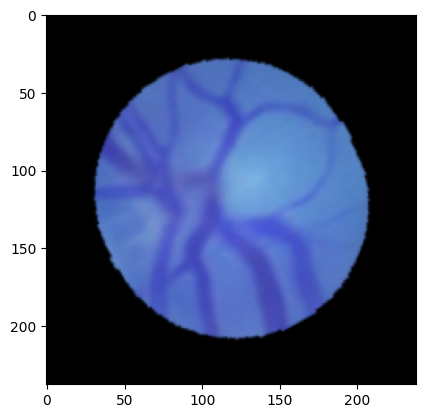

val


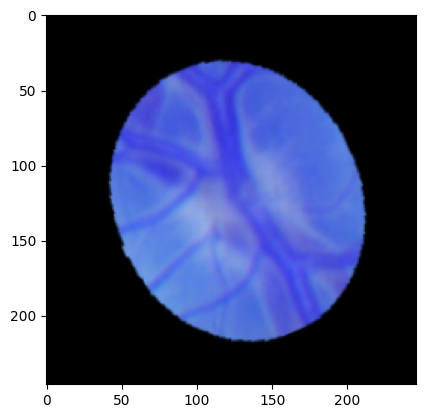

val


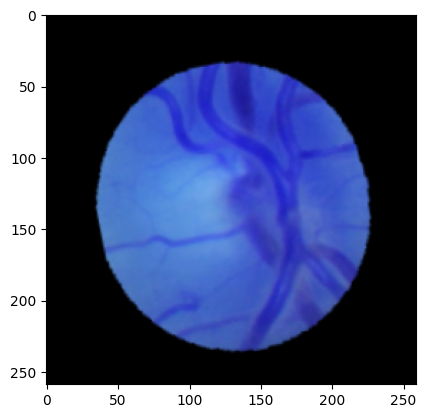

In [198]:
for i in range(2):
    print("train")
    imgplot = plt.imshow(train[i])
    plt.show()

for i in range(2):
    print("test")
    imgplot = plt.imshow(test[i])
    plt.show()

for i in range(2):
    print("val")
    imgplot = plt.imshow(val[i])
    plt.show()

Normalización

In [211]:
size = (224, 224)  # Tamaño deseado para las imágenes

train = [cv2.resize(img, size) for img in train]
test = [cv2.resize(img, size) for img in test]
val = [cv2.resize(img, size) for img in val]

In [212]:
x_train = np.array(train)
x_test = np.array(test)
x_val = np.array(val)

In [213]:
x_train = x_train/255.0
x_test = x_test/255.0
x_val = x_val/255.0

In [214]:
def data_class(data_path, size, class_mode):
    datagen = ImageDataGenerator(rescale = 1./255)
    classes = datagen.flow_from_directory(data_path,
                                          target_size = size,
                                          batch_size = 32,
                                          class_mode = class_mode)
    return classes

In [215]:
train_class = data_class(train_path, size, 'sparse')
test_class = data_class(test_path, size, 'sparse')
val_class = data_class(val_path, size, 'sparse')

Found 217 images belonging to 2 classes.
Found 174 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


In [216]:
y_train = train_class.classes
y_test = test_class.classes
y_val = val_class.classes

In [217]:
train_class.class_indices

{'glaucoma': 0, 'normal': 1}

In [218]:
y_train.shape,y_test.shape, y_val.shape

((217,), (174,), (94,))

In [219]:
vgg = VGG19(input_shape = (224, 224, 3), weights = 'imagenet', pooling=GlobalAveragePooling2D,  include_top = True)
#vgg = VGG19(input_shape = (224, 224, 3), weights = '/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/vgg19_final_weights.h5', pooling=GlobalAveragePooling2D,  include_top = True)

In [220]:
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(3, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

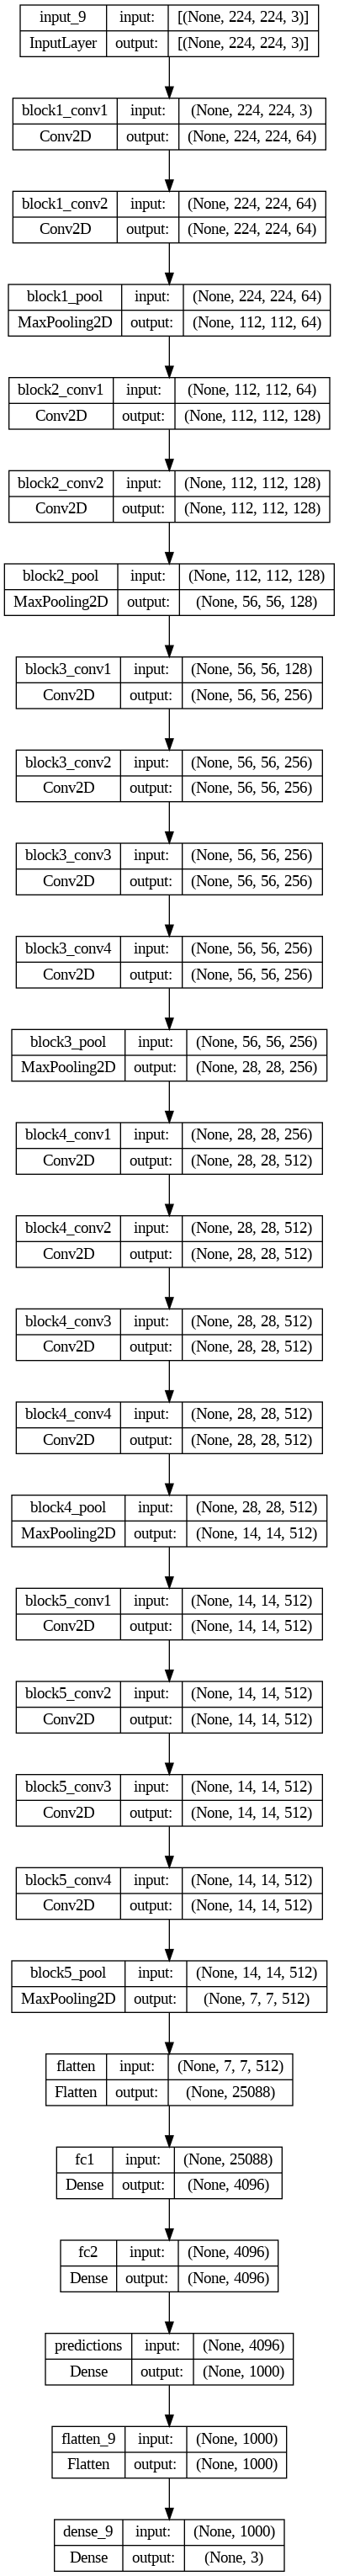

In [221]:
plot_model(model=model, show_shapes=True)

In [222]:
early_stop = EarlyStopping(monitor = 'val_loss', mode='min', verbose = 1, patience = 7)

In [125]:
early_stop = EarlyStopping(monitor = 'accuracy', mode='max', verbose = 1, patience = 7)

In [223]:
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 10, callbacks=[early_stop], batch_size = 10,
                    shuffle=True)

Epoch 1/10
22/22 [==============================] - 4s 124ms/step - loss: 1.0879 - accuracy: 0.5622 - val_loss: 1.0742 - val_accuracy: 0.6277
Epoch 2/10
22/22 [==============================] - 2s 95ms/step - loss: 1.0628 - accuracy: 0.6267 - val_loss: 1.0500 - val_accuracy: 0.6277
Epoch 3/10
22/22 [==============================] - 2s 91ms/step - loss: 1.0391 - accuracy: 0.6267 - val_loss: 1.0271 - val_accuracy: 0.6277
Epoch 4/10
22/22 [==============================] - 2s 93ms/step - loss: 1.0171 - accuracy: 0.6267 - val_loss: 1.0056 - val_accuracy: 0.6277
Epoch 5/10
22/22 [==============================] - 2s 97ms/step - loss: 0.9965 - accuracy: 0.6267 - val_loss: 0.9859 - val_accuracy: 0.6277
Epoch 6/10
22/22 [==============================] - 2s 95ms/step - loss: 0.9774 - accuracy: 0.6267 - val_loss: 0.9678 - val_accuracy: 0.6277
Epoch 7/10
22/22 [==============================] - 2s 95ms/step - loss: 0.9601 - accuracy: 0.6267 - val_loss: 0.9505 - val_accuracy: 0.6277
Epoch 8/10
2

Visualización

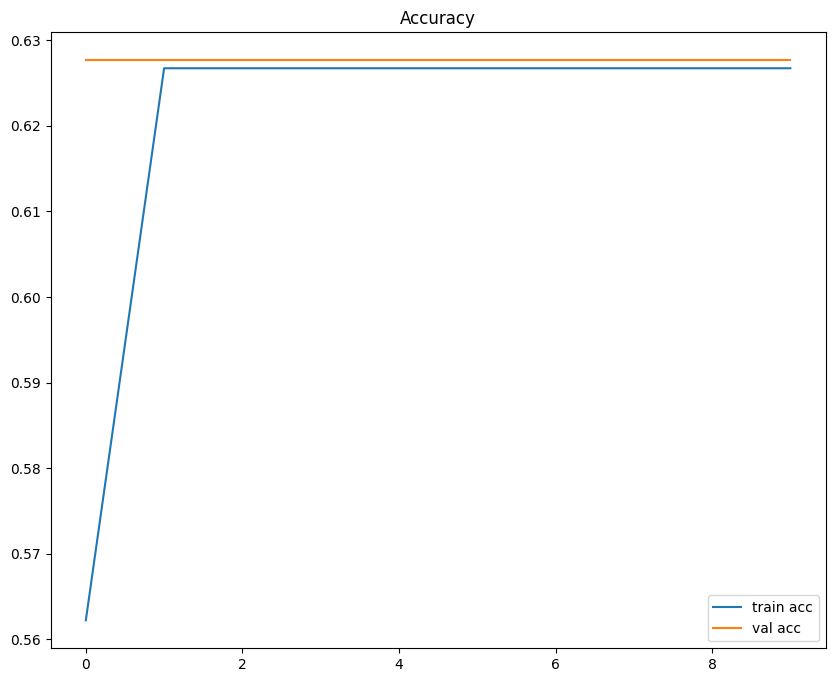

In [224]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()

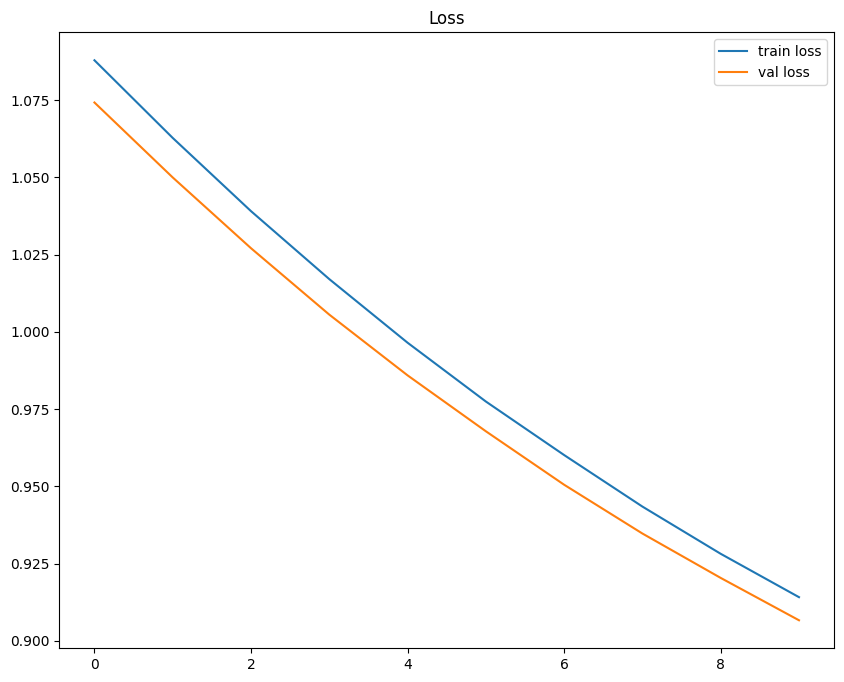

In [225]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

Evaluacion_Modelo

In [226]:
model.evaluate(x_test, y_test, batch_size=10)

18/18 [==============================] - 1s 64ms/step - loss: 0.8942 - accuracy: 0.6782


[0.8941641449928284, 0.6781609058380127]

In [227]:
y_pred = model.predict(x_test)

6/6 [==============================] - 1s 147ms/step


In [228]:
y_pred=np.argmax(y_pred,axis=1)

In [229]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.68      0.81       174

    accuracy                           0.68       174
   macro avg       0.50      0.34      0.40       174
weighted avg       1.00      0.68      0.81       174



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [230]:
precision_score(y_test, y_pred, average='micro')

0.6781609195402298

Eliminar los txt que nos da para la segmentacion y quedarnos solo con las imagenes

In [137]:
import os
from google.colab import drive
drive.mount('/content/drive')

# Directorio en el que deseas eliminar los archivos .txt
directorio = '/content/drive/My Drive/Tesis/Proyectos1/Tecnica2/Hospital/RIM-ONE_segmentation/Normal'

# Itera sobre todos los archivos en el directorio
for archivo in os.listdir(directorio):
    if archivo.endswith('.txt'):
        archivo_completo = os.path.join(directorio, archivo)
        os.remove(archivo_completo)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
